# Technology focus: Visium HD

In this notebook, we will present an overview of the plotting functionalities of the `spatialdata` framework in the context of a Visium HD dataset.

## Challenges in plotting the data

Before showing the code, here is are some short considerations on the challenges that arise when handling and plotting Visium HD data, and how we provide methods to address them within the `spatialdata` framework.

### Data dimensions

Let's first have a quick recap of the data dimensions on hand.
- The Visium HD capture location area is 6.5mm x 6.5mm in size.
- The smallest capture locations (bins) are 2µm x 2µm, leading to up to around 10.5 million bins per dataset.
- In the dataset used in this notebook, around 20000 genes are considered.
- The data is very sparse. In the dataset used in this notebook, only around 5.5 million of the bins are actually covering parts of the tissue where gene expression is detected. Even within these bins, most of the genes are not expressed (more on this below).

### Raster vs vector data representation

The bins are arranged in a 3250 x 3250 regular grid, so a natural way to represent the data would be as an image. Nevertheless, due to large number of genes, using a purely raster representation is not feasible.
In fact, assuming using a `uint8` data type (1 byte) for recording, for each bin, a number from 0 to 255, rasterizing the full data would require 3250 x 3250 x 19059 = 187 GBs!

A more memory-efficient approach, that we adopt, is to decouple the spatial locations and the gene expression information:
- spatial locations are represented as vector geometries (squares (default), circles or points) and are at most around 10.5 million;
- gene expression information is stored as a `AnnData` table with sparse compressed representation (compressed sparse rows by default); in this dataset there are around 130 million non-zero entries.

For the current dataset, assuming 1 byte per table entry, this would require around 130 MB of memory, much less than the upper limit 187 GB.

### The data representation is flexible

As we said above, we represent Visium HD data as a combination of squares and `AnnData` tables with a compressed sparse rows matrix. Nevertheless, there are cases where the user may have specific need for a data representation over the other; here is a list of examples of what `spatialdata` offers.

- The compressed sparse rows matrix representation efficiently accesses all the genes expressed in a particular bin; there are cases where one wants to go the other way around and efficiently access all the locations expressing a particular gene. The `AnnData` API `tocsc()` allows switching to a compressed sparse column representation.
- Raster vs vector representation. We explained above that a fully rasterized version of the data is not memory efficient; nevertheless, if the user just wants to visualize a small number of genes, the memory impact would be small. In such cases, visualizing with raster objects is generally much more performant than visualizing shapes and geometries. Thanks to the function `rasterize_bins()`, we can construct a lazy image that computes a rasterization on-demand, bridging the benefit of our lightweight vector data representation and in-memory raster representation. As we will explain, the `rasterize_bins()` produces a raster image that is aware of the coordinate transformations, so no matter the bin size considered, the data is always aligned with the high-resolution H&E image.

We will show all of this below.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

## Loading the data

A reader for Visium HD data is available in `spatialdata-io`. We used it to parse and convert to Zarr a [Visium HD dataset of a Mouse Small Intestine (FFPE)](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine).

We provide the already-converted Zarr data [available for download here](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_hd_3.0.0_io.zip).

Please download the data, rename the `.zarr` store to `visium_hd.zarr` and place it in the current folder (in alternative you can use symlinks to make the data visible).

In [2]:
visium_hd_zarr_path = "./visium_hd.zarr"

A note on data loading. The data requires ~10 seconds to load because, while we support the lazy representation of images, labels, and points, the shapes, geometries, and annotation tables are currently not represented lazily. This is one of the first spatial omics datasets that reaches a scale for which this is required. We will make a new release to allow for lazy representation also of these data types. See the discussion here https://github.com/scverse/spatialdata/issues/293#issuecomment-1657290681.

In [3]:
%%time
import spatialdata as sd

sdata = sd.read_zarr(visium_hd_zarr_path)
sdata

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


CPU times: user 8.98 s, sys: 1.82 s, total: 10.8 s
Wall time: 9.73 s


SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/visium_hd_3.0.0_io/data.zarr
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Shapes': GeoDataFrame shape: (2, 1) (2D shapes)
│     ├── 'Shapes_external': GeoDataFrame shape: (1, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (91033, 1) 

The dataset contains 1 large microscopy image, represented as a multiscale, chunked image, two explicit downscaled versions of it, and one CytAssist image.

Also, the image dataset contains the data at the highest resolution (2µm bins) and two downsampled (binned) versions of it, which have respectively bin sizes of 8µm and 16µm.

In [4]:
# let's make the var names unique; this improves performance in accessing the tabular data and is necessary to be able to plot the data
for table in sdata.tables.values():
    table.var_names_make_unique()

## Plotting the images

Let's visualize the images.

INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Rasterizing image for faster rendering.                                                                   


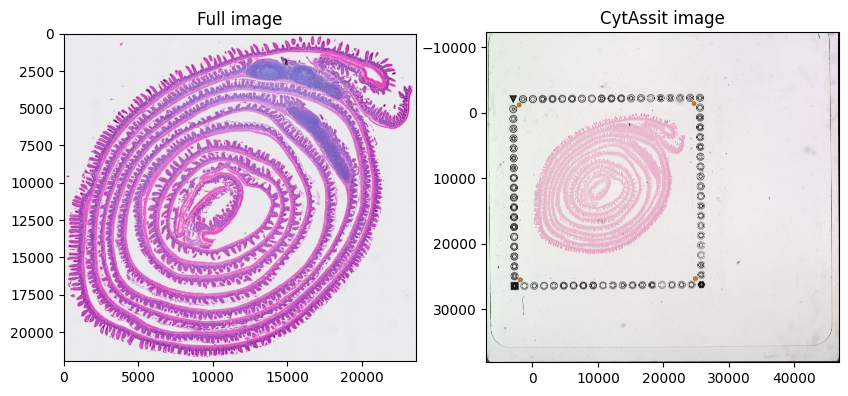

In [5]:
import matplotlib.pyplot as plt
import spatialdata_plot

axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_cytassist_image").pl.show(ax=axes[1], title="CytAssit image")

Let's plot the same range for the 2 images; to achieve this we first compute the extent of the first image with `spatialdata.get_extent()` and then crop the second data using the `spatialdata` query APIs.

Please note that setting the plotting lim (`ax.set_xlim()`, ...) after plotting may lead to lower image quality because the data is plotted at the optimal resolution for the full extent, but then a portion of it is zoomed in.

In [6]:
from spatialdata import get_extent

data_extent = get_extent(sdata["Visium_HD_Mouse_Small_Intestine_full_image"], coordinate_system="global")
data_extent

{'y': (0.0, 21943.0), 'x': (0.0, 23618.0)}

In [7]:
from spatialdata import bounding_box_query

queried_cytassist = bounding_box_query(
    sdata["Visium_HD_Mouse_Small_Intestine_cytassist_image"],
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system="global",
)
sdata["queried_cytassist"] = queried_cytassist

INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   


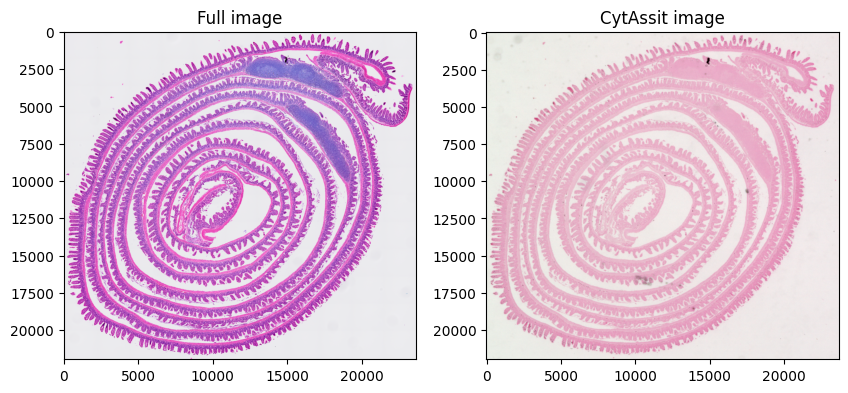

In [8]:
axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show(ax=axes[1], title="CytAssit image")

Let's focus the visualization on a smaller region so we can appreciate the better resolution of the first image. Here, we create cropped versions of the `SpatialData` objects on the fly using an anonymous function.

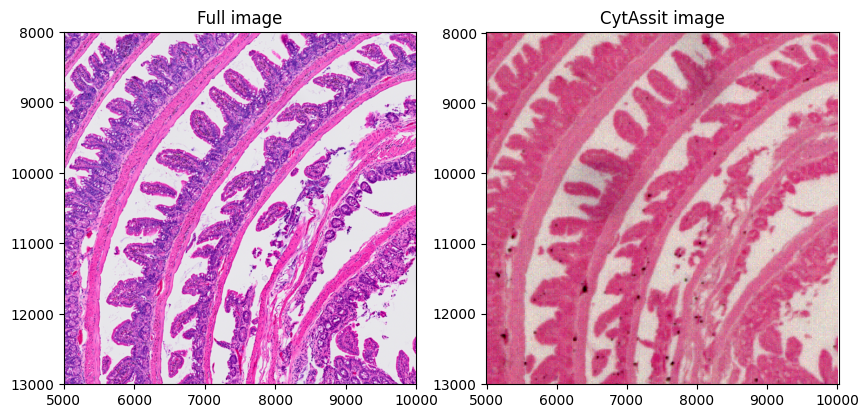

In [9]:
axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
crop0 = lambda x: bounding_box_query(
    x, min_coordinate=[5000, 8000], max_coordinate=[10000, 13000], axes=("x", "y"), target_coordinate_system="global"
)
crop0(sdata).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(
    ax=axes[0], title="Full image", coordinate_systems="global"
)
crop0(sdata).pl.render_images("queried_cytassist").pl.show(
    ax=axes[1], title="CytAssit image", coordinate_systems="global"
)

## Plotting the gene expression data

Let's plot the bins colored by gene expression. For now, we will use the largest bin size. Later in the notebook, we will make plots using the two smaller bin sizes on a cropped version of the data. 

We will first plot the data as they are natively represented (squares), then show how to efficiently plot a rasterized version using `rasterize_bins()`.

### Plotting the vector geometries

The following code plots the data where the bins are represented as vector geometries.

INFO     Using 'datashader' as plotting backend.                                                                   
CPU times: user 20 s, sys: 14.2 s, total: 34.2 s
Wall time: 41.9 s


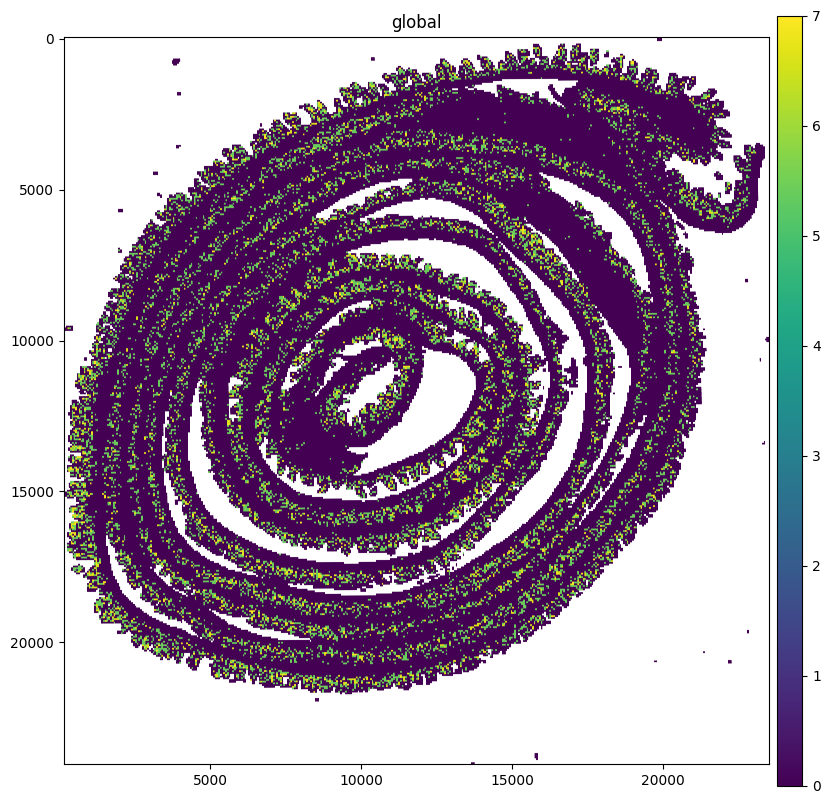

In [10]:
%%time
plt.figure(figsize=(10, 10))
ax = plt.gca()

gene_name = "AA986860"
sdata.pl.render_shapes("Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name, method="datashader").pl.show(
    coordinate_systems="global", ax=ax
)

### Performant on-the-fly data rasterization

Let's now pre-compute a lazy-rasterized version of the data using `rasterize_bins()`. This operation takes just a few seconds and unlocks very fast on-demand channel-wise rasterization.

In [11]:
%%time
from spatialdata import rasterize_bins

for bin_size in ["016", "008", "002"]:
    # rasterize_bins() requires a compresed sparse column (csc) matrix
    sdata.tables[f"square_{bin_size}um"].X = sdata.tables[f"square_{bin_size}um"].X.tocsc()
    rasterized = rasterize_bins(
        sdata,
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size}um",
        f"square_{bin_size}um",
        "array_col",
        "array_row",
    )
    sdata[f"rasterized_{bin_size}um"] = rasterized

CPU times: user 4.23 s, sys: 1.25 s, total: 5.48 s
Wall time: 5.59 s


This produces lazy image objects that can be accessed gene-wise exceptionally efficiently. 

Importantly, these objects should **not** be computed as a whole, because this would lead to the unnecessary computation of hundreds of GB of memory.

In [12]:
%%time
# this is very fast
sdata["rasterized_002um"].sel(c=gene_name).compute()
# this must not be called
# sdata["rasterized_002um"].compute()

CPU times: user 12.7 ms, sys: 8.33 ms, total: 21 ms
Wall time: 20.4 ms


<xarray.DataArray 'image' (y: 3285, x: 3191)> Size: 42MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    c        <U8 32B 'AA986860'
  * y        (y) float64 26kB 0.5 1.5 2.5 3.5 ... 3.282e+03 3.284e+03 3.284e+03
  * x        (x) float64 26kB 0.5 1.5 2.5 3.5 ... 3.188e+03 3.19e+03 3.19e+03
Attributes:
    transform:  {'global': Sequence \n    Sequence \n        Affine (x, y -> ...

Here is an example of how to plot the rasterized data. Please pay attention to setting `scale="full"`; this is essential. If it is not set, `spatialdata-plot` will try
to re-rasterize the data to fit the canvas size and try to compute the whole object.

CPU times: user 246 ms, sys: 9.39 ms, total: 255 ms
Wall time: 254 ms


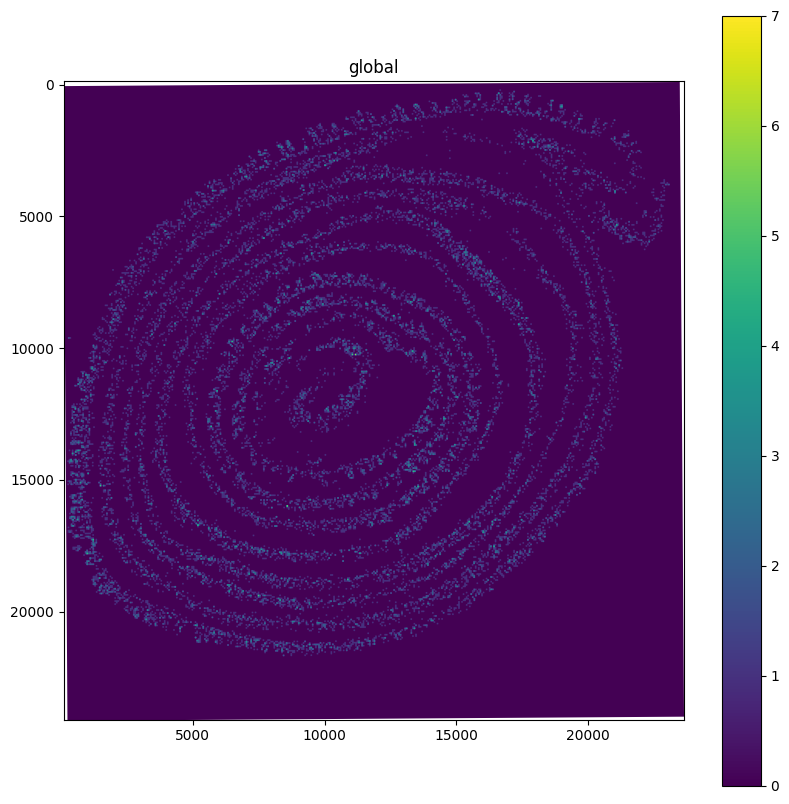

In [13]:
%%time
plt.figure(figsize=(10, 10))
ax = plt.gca()

sdata.pl.render_images("rasterized_016um", channel=gene_name, scale="full").pl.show(coordinate_systems="global", ax=ax)

As you can see below, we can plot the 2µm bins very performantly, which would not be possible with the `matplotlib` based approach shown before.

Note: when we plot the full data below the plot appears as uniformly violet. This happens because the data is very sparse and the bins are too small for the target figure size; since most of the non-zero bins are 1s the final interpolated colors are very close to the zero value and difficult to see.

Let's therefore:
1) change the limits of the plot to show a portion of the data to avoid interpolation artifacts
2) plot a binary mask of the full data to avoid the interpolated data to be to close to 0.

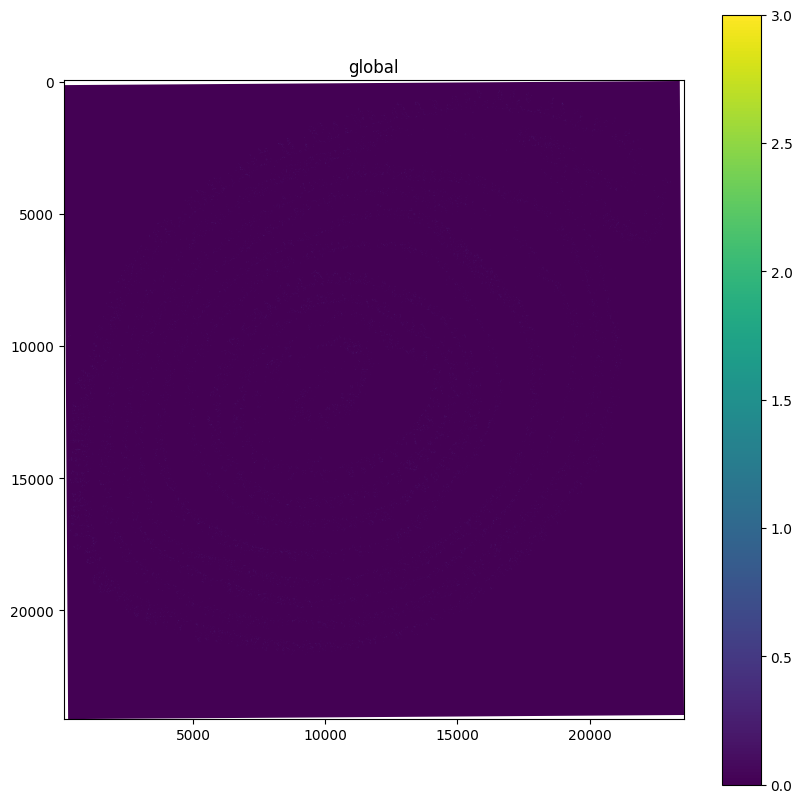

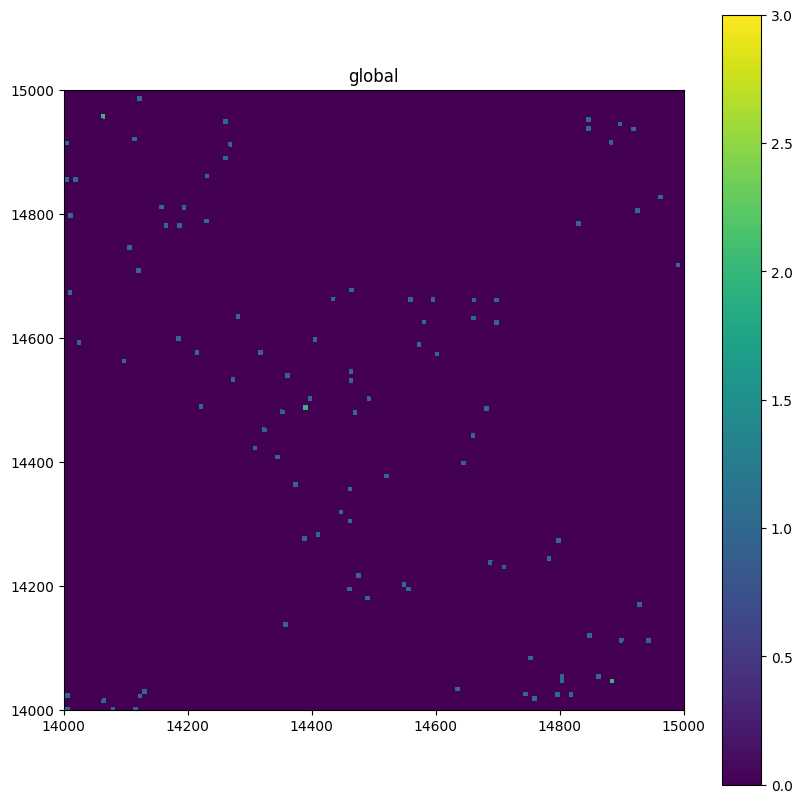

CPU times: user 852 ms, sys: 78.1 ms, total: 930 ms
Wall time: 930 ms


In [104]:
%%time

import matplotlib.colors
import numpy as np
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

for change_limits in [False, True]:
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    sdata.pl.render_images("rasterized_002um", channel=gene_name, scale="full", vmin=0, vmax=3).pl.show(
        coordinate_systems="global", ax=ax
    )
    sdata["rasterized_002um"]
    if change_limits:
        plt.xlim([14000, 15000])
        plt.ylim([14000, 15000])
plt.show()

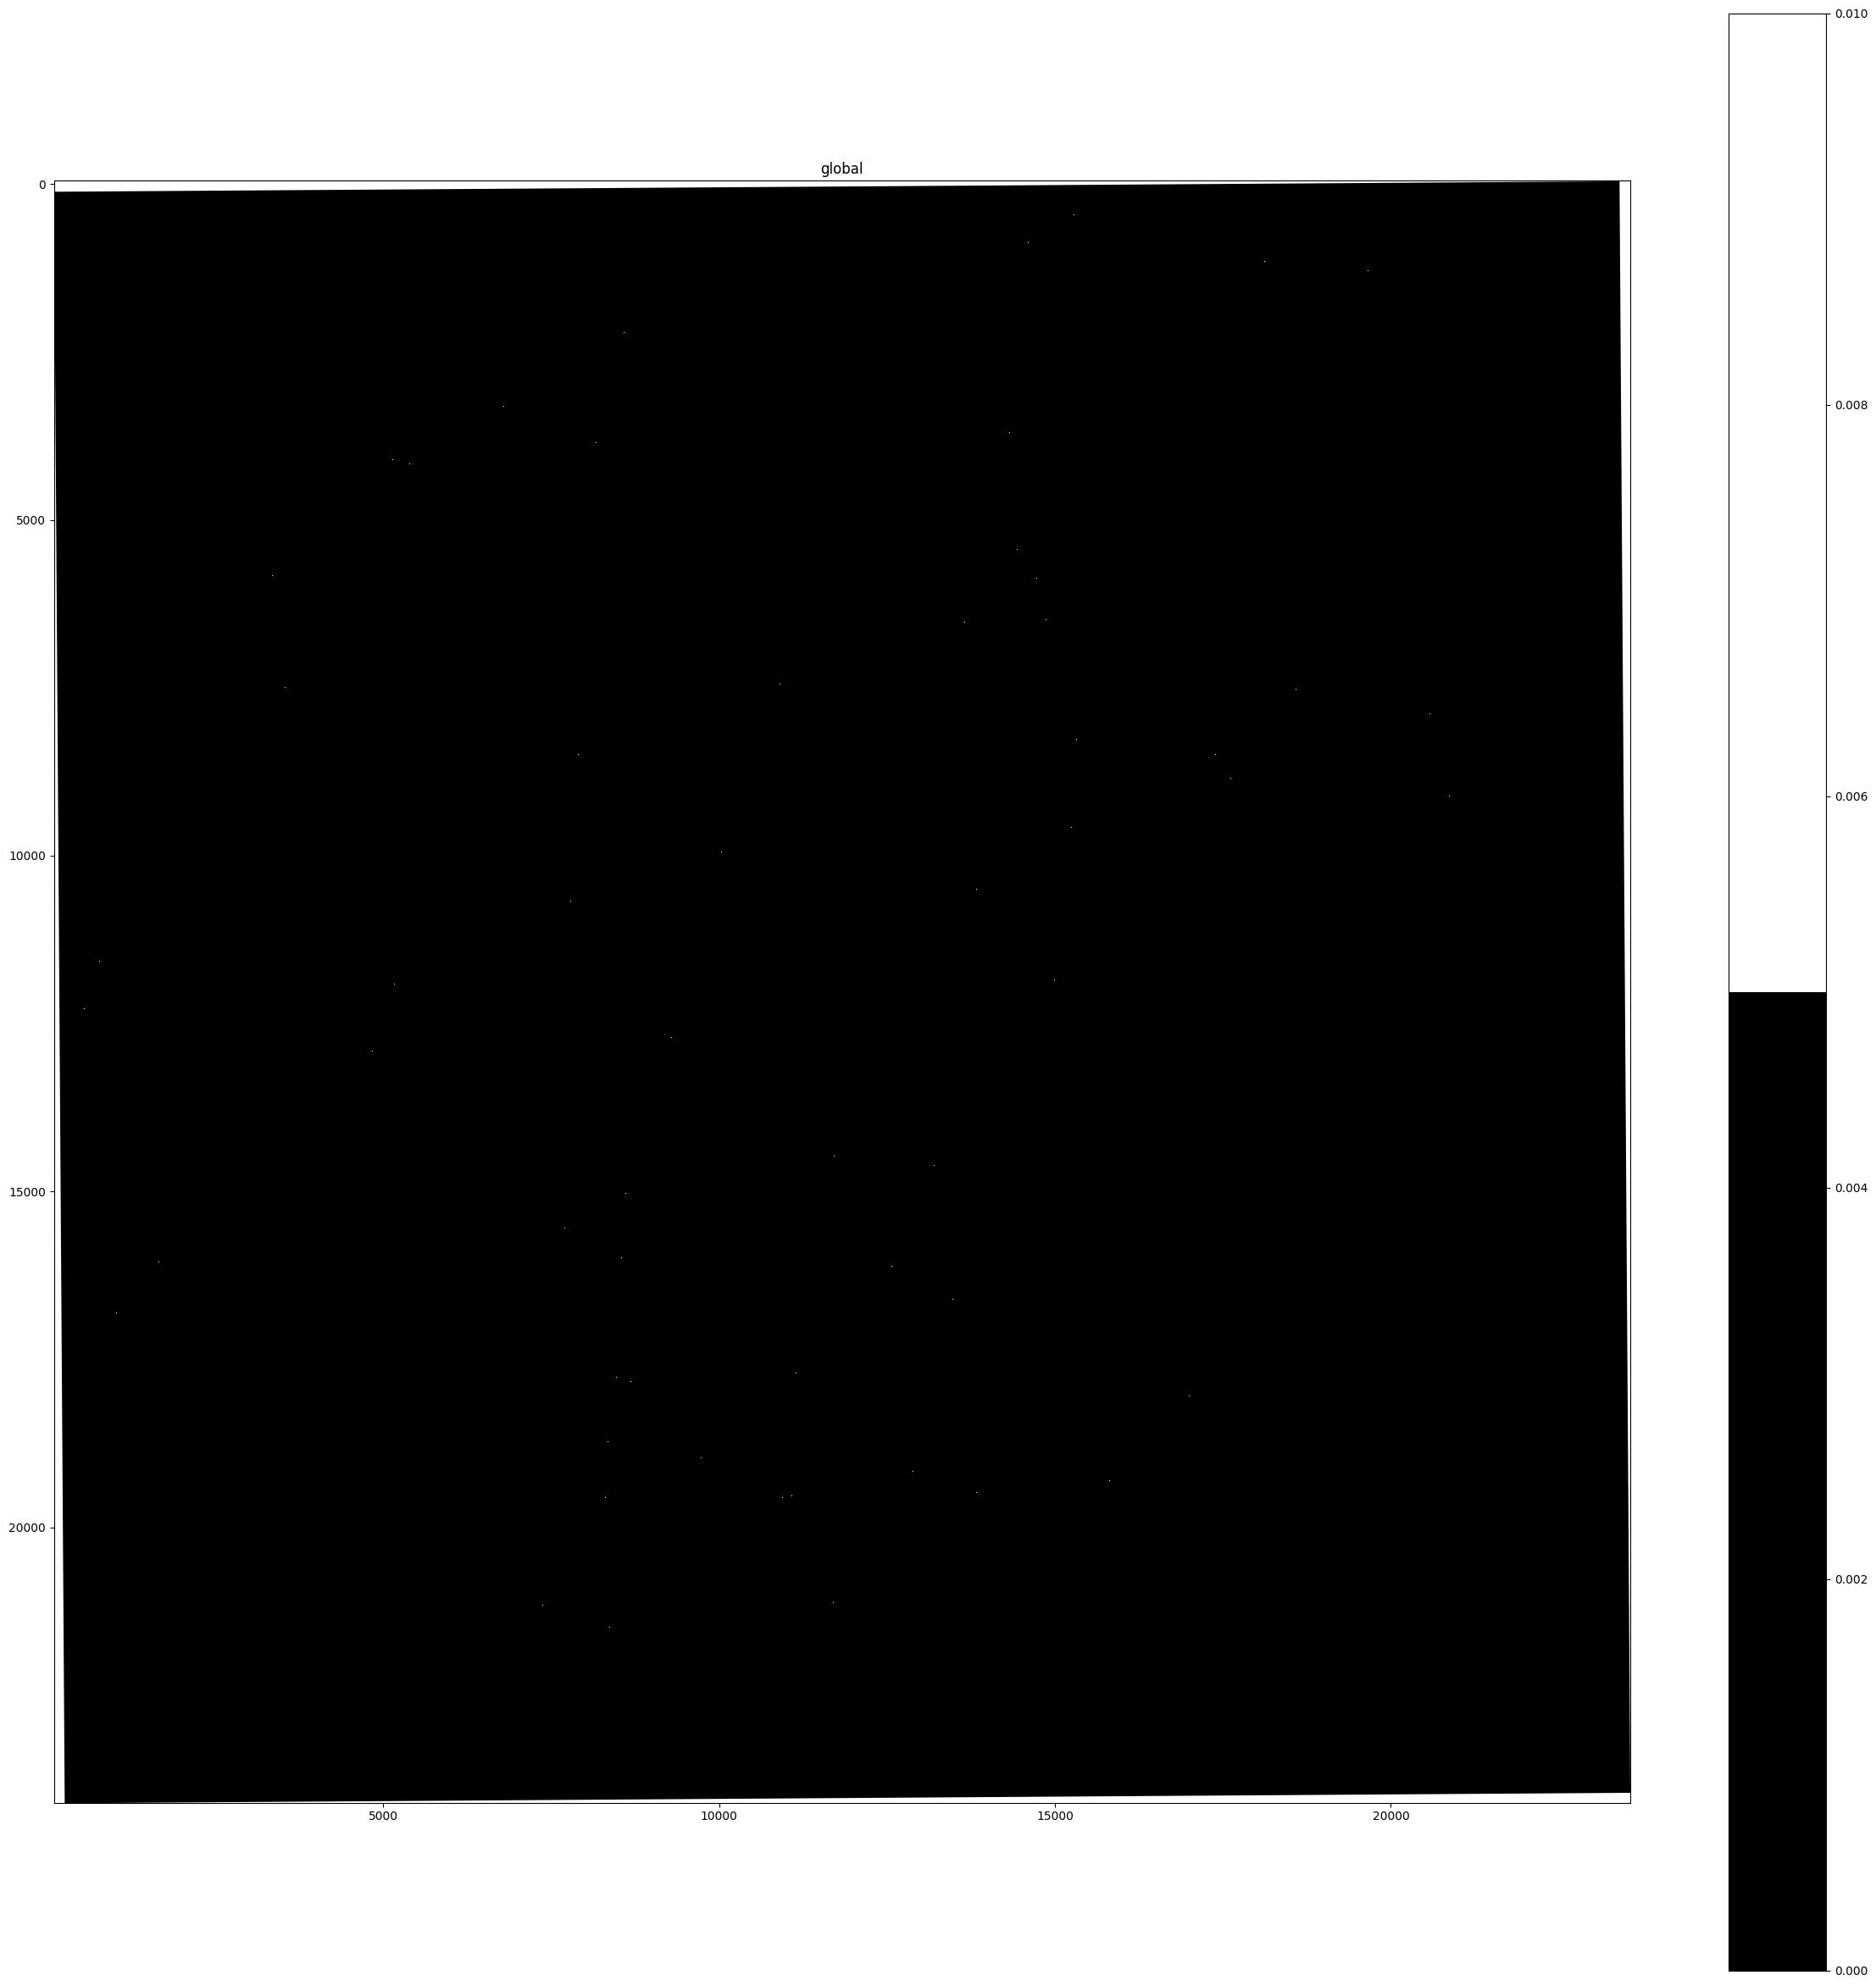

In [112]:
from matplotlib.colors import ListedColormap

# define the colors for the colormap (black for zeros, white for > 0)
colors = ["#000000", "#ffffff"]  # Black, White
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 10))

# bug: interpolation artifact, everything is black with a few sporadic white points: https://github.com/scverse/spatialdata-plot/issues/351
# ax = plt.gca()
# let's set a small vmax value so that the color is white also after interpolation
# sdata.pl.render_images("rasterized_002um", channel=gene_name, scale="full", vmin=0, vmax=0.01, cmap=cmap).pl.show(
# coordinate_systems="global", ax=ax
# )

# workaround
plt.imshow(sdata["rasterized_002um"].sel(c=gene_name).data.compute(), cmap=cmap, vmin=0, vmax=0.01)
plt.colorbar()

plt.show()

As a final not on the on-the-fly rasterization approach. Please, by looking at the corners of the last plot, notice how the data is on a grid that is actually sligthly rotated.
The advantage of using `rasterize_bins()` is that the produced object contains the coordinate transformations necessary to align (rotation and scale) the rasterized data together
with the high-resolution images.

### Plotting subsets of the data

Let's crop the data and make plots for all the bin sizes.

In [15]:
sdata_small = sdata.query.bounding_box(
    min_coordinate=[7000, 11000], max_coordinate=[10000, 14000], axes=("x", "y"), target_coordinate_system="global"
)

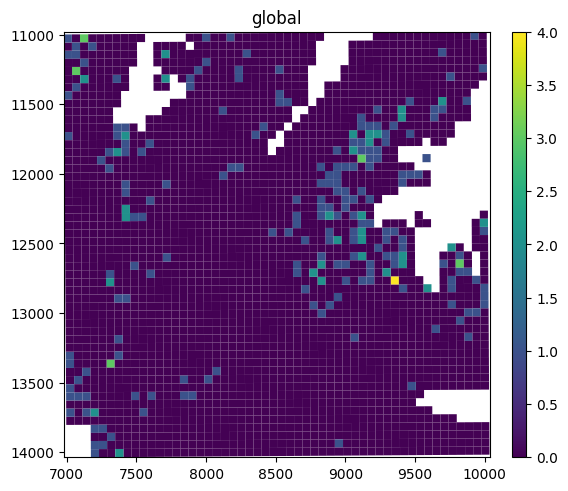

In [16]:
gene_name = "AA986860"
sdata_small.pl.render_shapes("Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name).pl.show(
    coordinate_systems="global"
)

Notice how a *Moiré pattern* is visible. This is due to the fact that the grid is not axis-aligned but presents a small rotation. A solution is to switch to datashader as a backend (which is enabled by default when the number of geometries is large). This will create some artifacts (bins of different sizes, some "holes" in the plot), but generally is expected to mitigate the effects as opposed the plot above.

INFO     Using 'datashader' as plotting backend.                                                                   


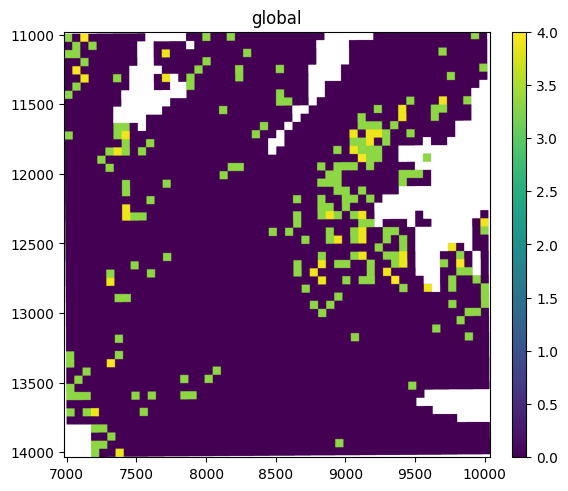

In [17]:
gene_name = "AA986860"
sdata_small.pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name, method="datashader"
).pl.show(coordinate_systems="global")

INFO     Using 'datashader' as plotting backend.                                                                   
INFO     Using 'datashader' as plotting backend.                                                                   


/opt/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


INFO     Using 'datashader' as plotting backend.                                                                   


/opt/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


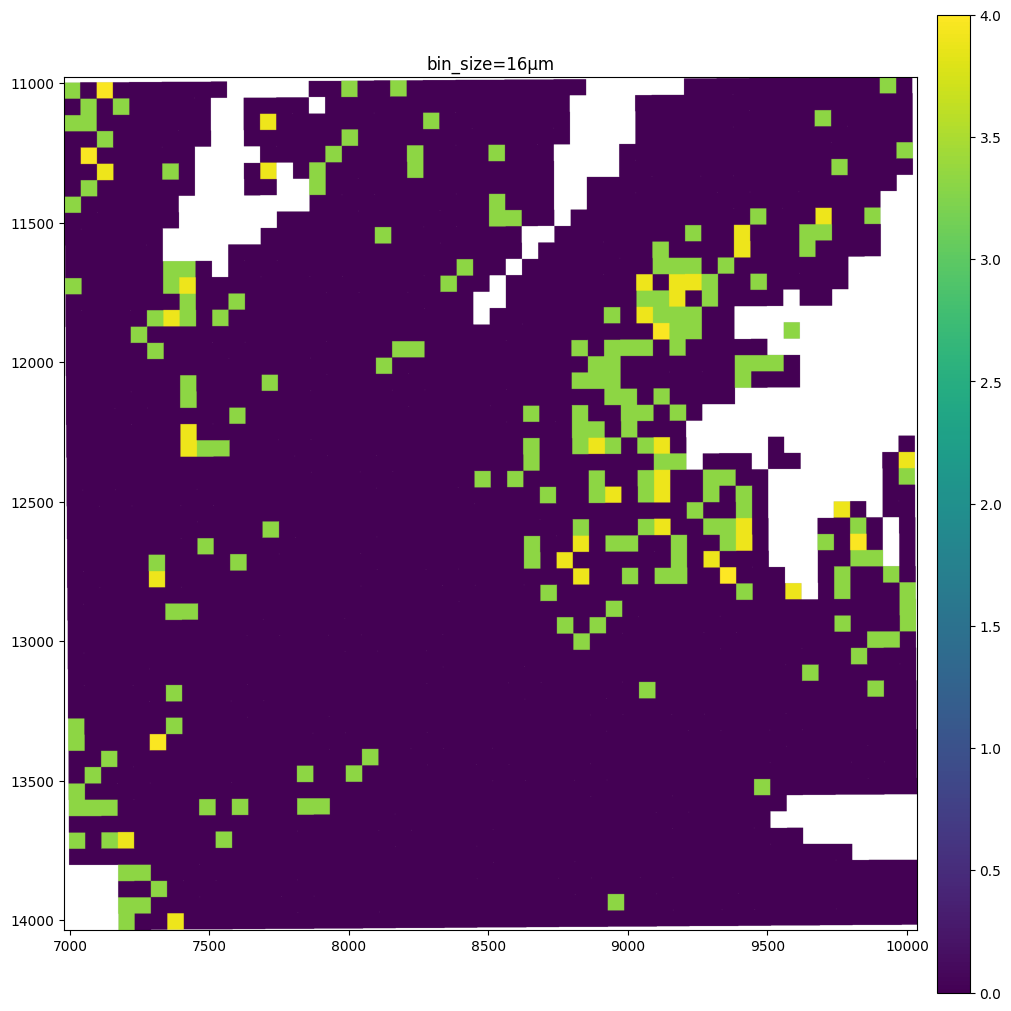

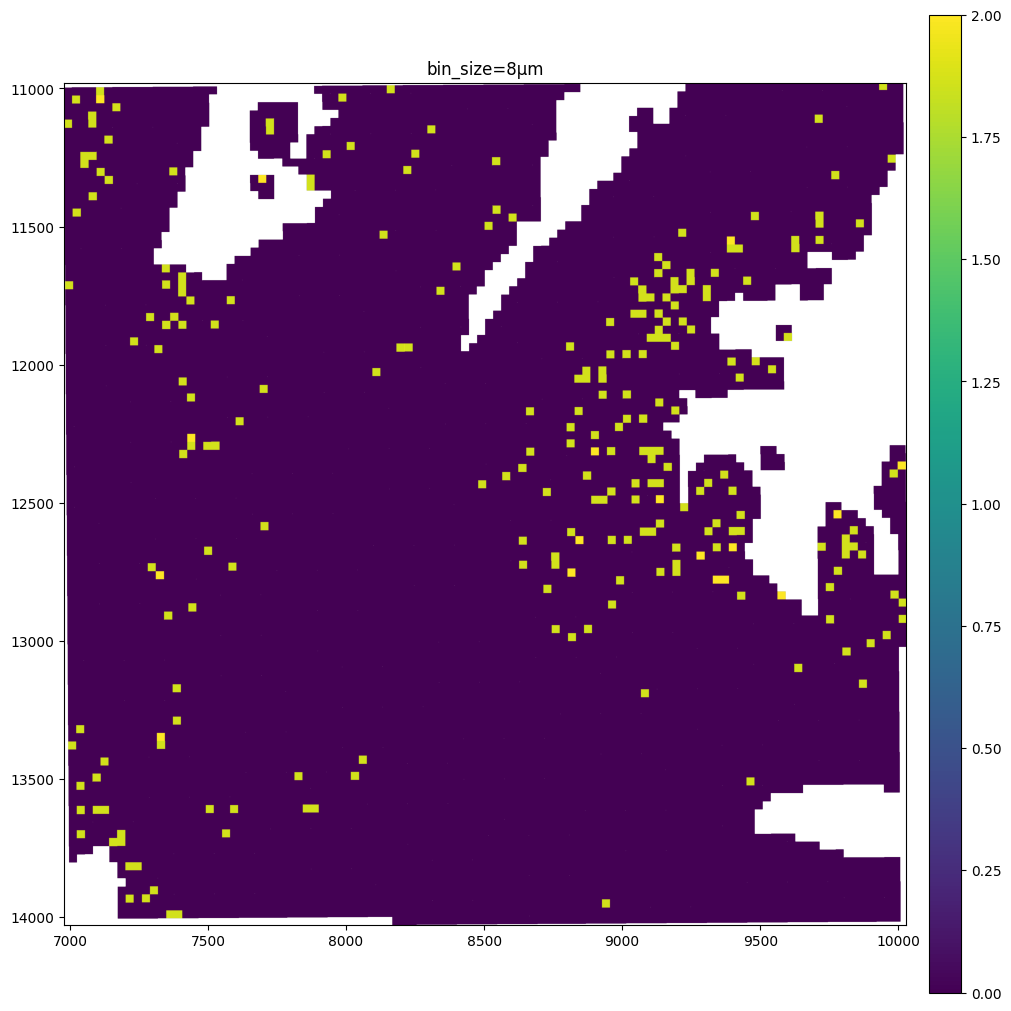

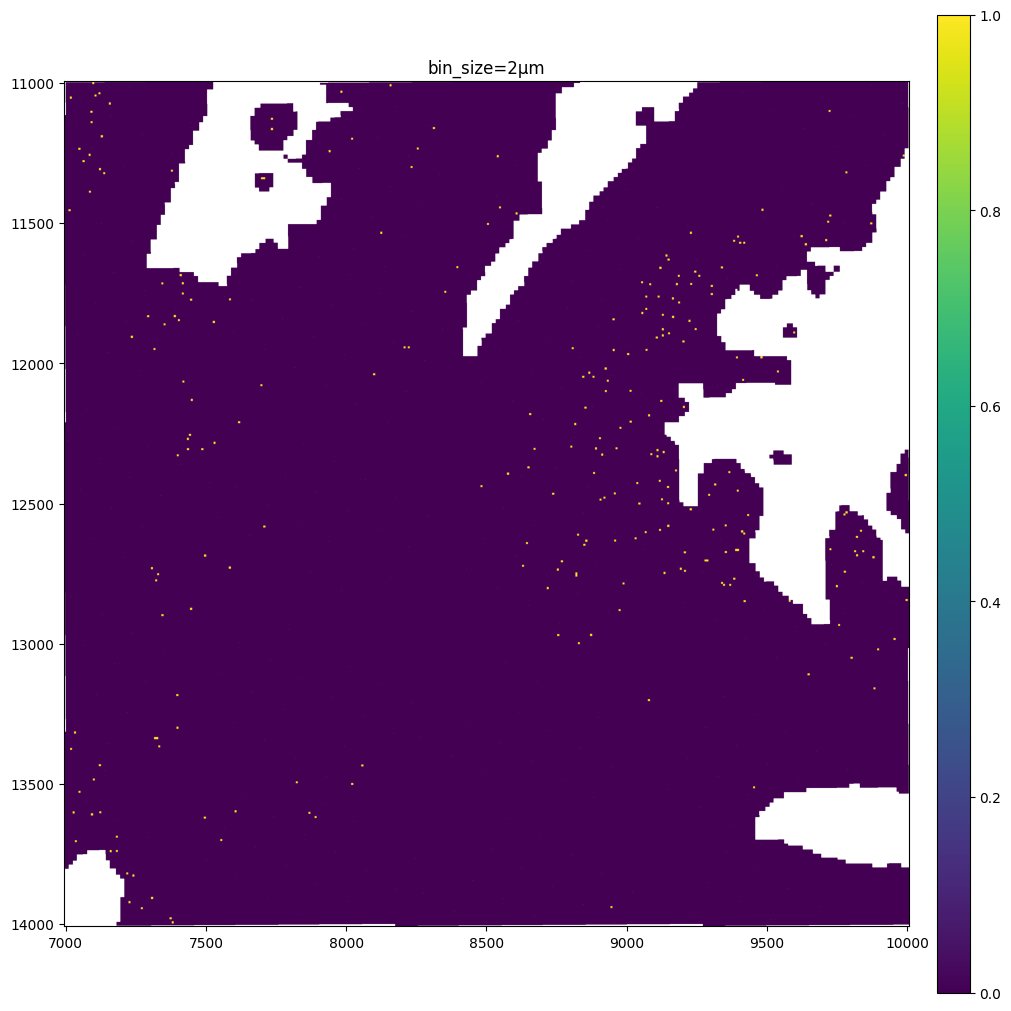

In [18]:
gene_name = "AA986860"

for bin_size in [16, 8, 2]:
    sdata_small.pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um",
        color=gene_name,
        method="datashader",
    ).pl.show(coordinate_systems="global", title=f"bin_size={bin_size}µm", figsize=(10, 10))

The data present a lot of sparsity. Let's remake the plots above by visualizing only the non-zero entries and using the full-resolution image as a background.

We will do this by modifying the viridis colormap so that 0 is plotted as transparent. Let's also truncate the viridis colormap so that the highest value is colored green and not yellow since green has a better contrast against the pink of the H&E microscopy image.

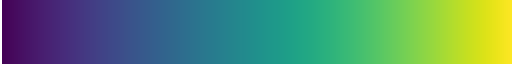

In [19]:
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

# let's display the areas where no expression is detected as transparent
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")
new_cmap

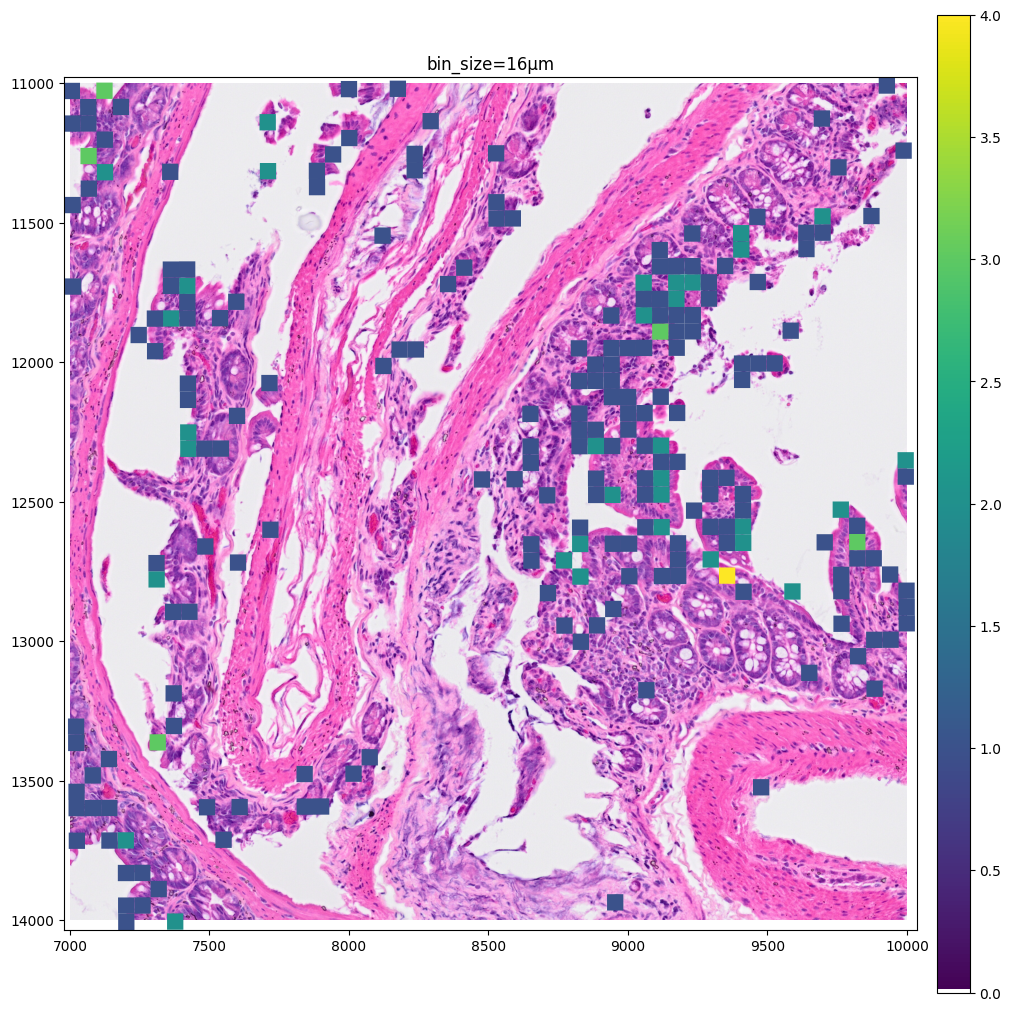

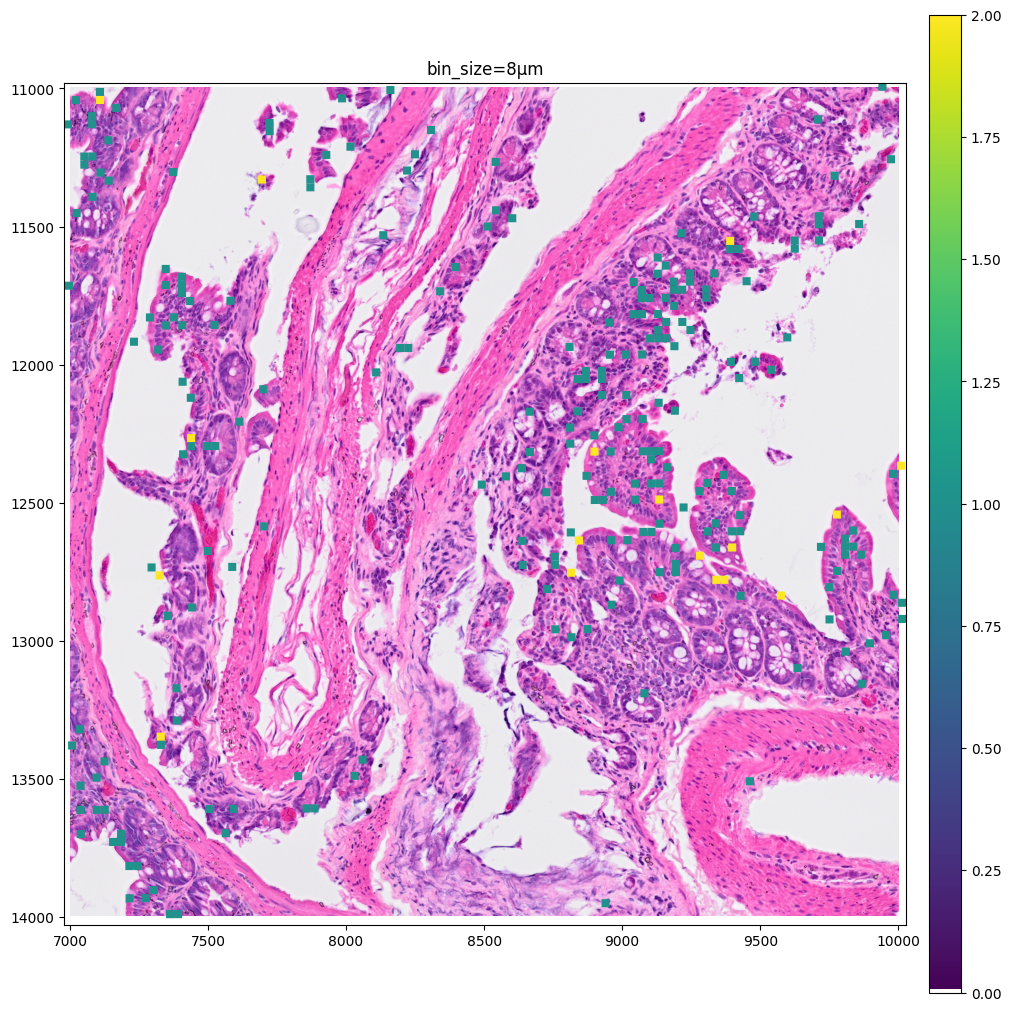

In [20]:
gene_name = "AA986860"

for bin_size in [16, 8]:
    sdata_small.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um", color=gene_name, cmap=new_cmap
    ).pl.show(coordinate_systems="global", title=f"bin_size={bin_size}µm", figsize=(10, 10))

Let's make a zoomed version of the plot for the 2µm bins to better visualize them. Please notice that we pass `method='matplotlib'` as currently this is required in order to visualize the background as transparent by means of the modified colormap.

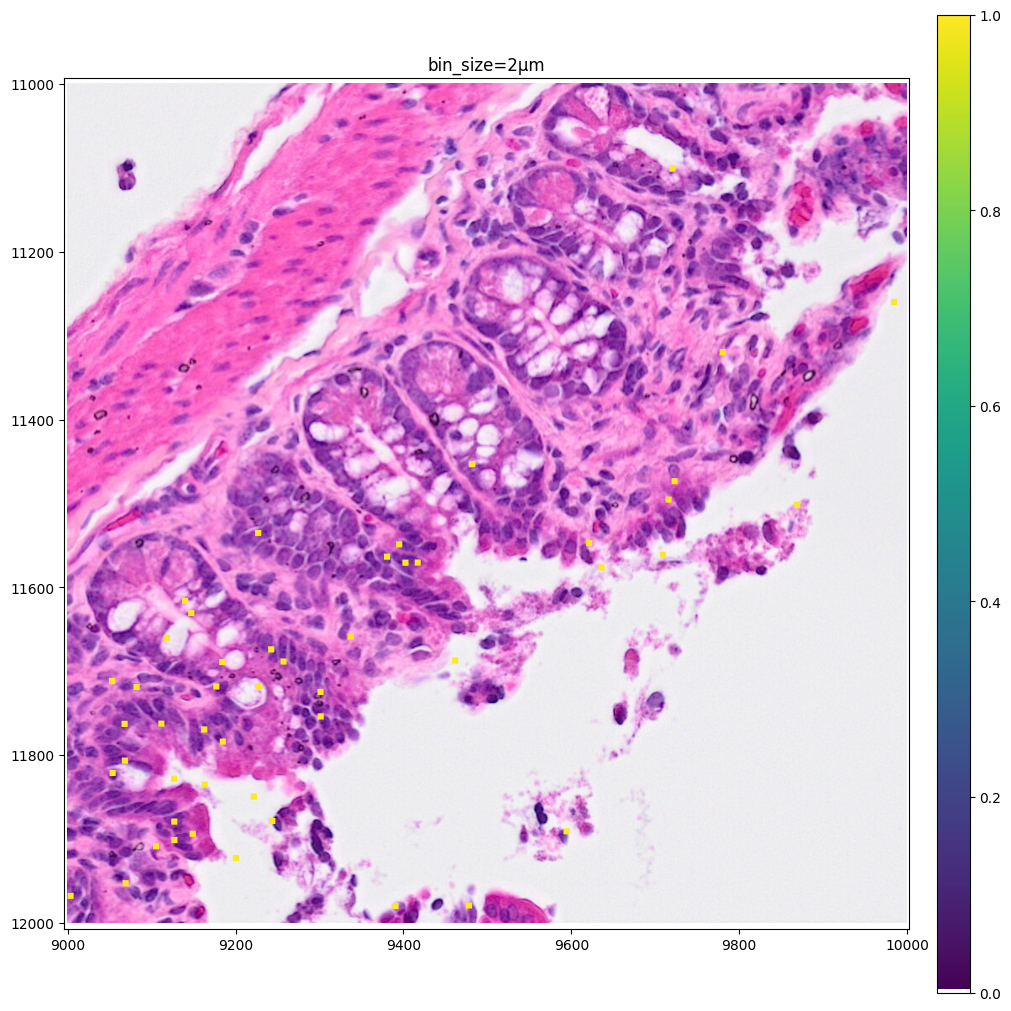

In [21]:
crop1 = lambda x: bounding_box_query(
    x, min_coordinate=[9000, 11000], max_coordinate=[10000, 12000], axes=("x", "y"), target_coordinate_system="global"
)
crop1(sdata_small).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_002um", color=gene_name, cmap=new_cmap, method="matplotlib"
).pl.show(coordinate_systems="global", title=f"bin_size=2µm", figsize=(10, 10))

As you can see the 8µm bins are convenient for looking at gene expression distribution from a broad perspective (same for the 16µm bins, where some resolution can be sacrificed in exchange for a faster visualization). On the other hand, the 2µm bins allow to precisely locate the expressed genes in the tissue.

## Plotting clusters

Let's now color the 16µm bins by cluster identity. Let's reuse the clusters `gene_expression_graphclust` computed from 10x Genomics and available with the raw data from the 10x Genomics website.

In [22]:
import os
from tempfile import TemporaryDirectory

import pandas as pd
import requests

# For convenience we rehost the single file containing the clusters we are interested in.
# Let's download it in a temporary directory and read it in a pandas DataFrame. The file is 2 MB.
clusters_file_url = "https://s3.embl.de/spatialdata/misc/visium_hd_mouse_intestine_16um_graphclust.csv"

with TemporaryDirectory() as tmpdir:
    path = os.path.join(tmpdir, "data.csv")
    response = requests.get(clusters_file_url)
    with open(path, "wb") as f:
        f.write(response.content)
    df = pd.read_csv(path)

In [23]:
df.head(3)

Barcode  Cluster
0  s_016um_00144_00175-1        3
1  s_016um_00145_00029-1        7
2  s_016um_00165_00109-1        8

In [24]:
# let's convert the Cluster dtype from int64 to categorical since later we want the plots to use a categorical colormap
df["Cluster"] = df["Cluster"].astype("category")
df.set_index("Barcode", inplace=True)

In [25]:
sdata["square_016um"].obs.head(3)

in_tissue  array_row  array_col  location_id  \
s_016um_00144_00175-1          1        144        175            0   
s_016um_00145_00029-1          1        145         29            1   
s_016um_00165_00109-1          1        165        109            2   

                                                             region  
s_016um_00144_00175-1  Visium_HD_Mouse_Small_Intestine_square_016um  
s_016um_00145_00029-1  Visium_HD_Mouse_Small_Intestine_square_016um  
s_016um_00165_00109-1  Visium_HD_Mouse_Small_Intestine_square_016um

Let's merge the data.

In [26]:
sdata["square_016um"].obs["Cluster"] = df["Cluster"]

Let's plot the clusters on one of the data crops we used before.

/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


CPU times: user 2.88 s, sys: 620 ms, total: 3.5 s
Wall time: 3.47 s


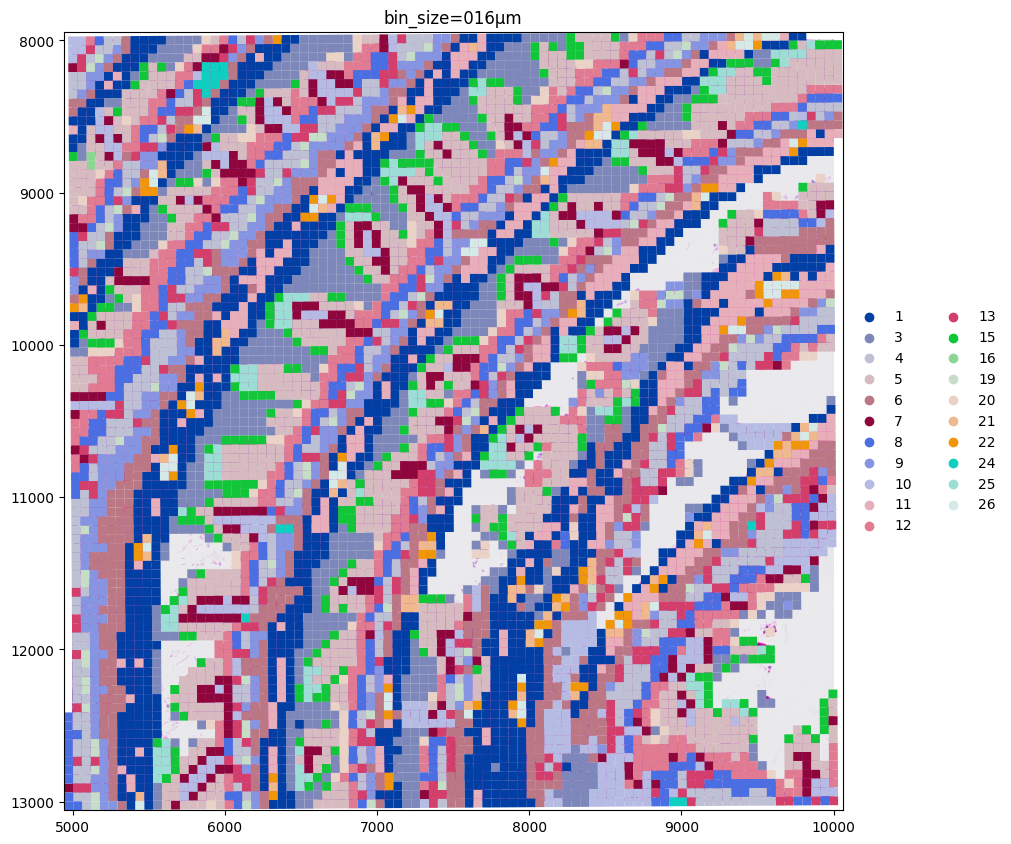

In [27]:
%%time
crop0(sdata).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um", color="Cluster"
).pl.show(coordinate_systems="global", title=f"bin_size=016µm", figsize=(10, 10))

## Interactive visualization with napari

### Vector-based visualization

To conclude the example here is a screenshot of `napari-spatialdata` used to visualize the data on 16µm bins. Currently `napari`'s performance is not optimized for the visualization of large collections of polygonal data (we are working on improving this together with the `napari` developers); this warning is displayed as a tooltip when the user hovers the mouse above the warning symbols in the bottom left of the window.

![image.png](attachments/napari_visium_hd.png)

One way to improve the performance is to convert the polygonal data to simpler vector representations, such as circles or points. This can be achieved via the `to_circles()` and `get_centroids()` spatialdata APIs. But a better approach is to switch to a raster-based visualization. 

### Raster-based visualization

To overcome the above limitations, you can proceed with the on-demand rasterization approach that we explained above by simply selecting the `rasterized_002um`, `rasterized_008um`, and `rasterized_002um` layers. Here are two animations showing this approach.

The first shows the equivalence between the vector shapes (circles) and the rasterized version, in this case using the 16µm bins data.

![image.png](attachments/napari_visium_hd_animation0.gif)

The second showcases the perfomane of the viewer on the 2µm bins data.

![image.png](attachments/napari_visium_hd_animation1.gif)